# Description
This notebook compares the results of training a Conditional Normalizing Flow model on the synthetic two moons data. The data have rotation and moon class as conditioning variables.

The comparison is between a base flow with no regularization at all and adding in Clipped Adam and Batchnormalization.

Lots of different hyperparamters are tested to see if we can get batch normalization to work

# Base loads

In [1]:
!pip install pyro-ppl==1.3.0

     |████████████████████████████████| 501kB 8.6MB/s 


In [2]:
!nvidia-smi

Sun Jun 14 22:02:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import folium
import datetime

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


import numpy as np
import folium
from folium import plugins
import matplotlib
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Mount my drive
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Load Git code

In [5]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
Already up to date.
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling, normalizing_flow_factory, conditional_normalizing_flow_factory
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples, simple_data_split_conditional, simple_data_split, circle_transform
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler
from DEwNF.regularizers import NoiseRegularizer, rule_of_thumb_noise_schedule, approx_rule_of_thumb_noise_schedule, square_root_noise_schedule, constant_regularization_schedule


# Func def

In [0]:
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def rescale_samples(plot_flow_dist, scaler, n_samples=256):
    x_s = plot_flow_dist.sample((n_samples,))
    if x_s.is_cuda:
        x_s = x_s.cpu()
    if scaler is not None:
        x_s = scaler.inverse_transform(x_s)
    return x_s

def add_marker_w_prob(coords, obs_scaler, flow_dist, hub_map, name):
    scaled_coords = obs_scaler.transform(np.flip(np.array([coords])))
    log_prob = flow_dist.log_prob(torch.tensor(scaled_coords).float().cuda()).cpu().detach().numpy()
    folium.CircleMarker(
    location=coords,
    popup=folium.Popup(f'{name} log likelihood: {log_prob}', show=True),
    icon=folium.Icon(icon='cloud')
    ).add_to(hub_map)

def create_overlay(shape, bounds, flow_dist, hub_map, cm, flip):
    with torch.no_grad():
        nlats, nlons = shape
        
        lats_array = torch.linspace(start=bounds[1][0], end=bounds[0][0], steps=nlats)
        lons_array = torch.linspace(start=bounds[0][1], end=bounds[1][1], steps=nlons)
        x, y = torch.meshgrid(lats_array, lons_array)

        points = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1)

        if flip:
            points = points.flip(1)

        scaled_points = torch.tensor(obs_scaler.transform(points), requires_grad=False).float()

        data = flow_dist.log_prob(scaled_points.cuda()).reshape(nlats,nlons).cpu().detach().numpy()
        data = np.exp(data)
        overlay = cm(data)

    folium.raster_layers.ImageOverlay(
    image=overlay,
    bounds=bounds,
    mercator_project=False,
    opacity=0.75
    ).add_to(hub_map)

    return overlay


def plot_samples(samples, hub_map):

    for point in samples:
        folium.CircleMarker(
        location=point,
        radius=2,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        opacityb=0.1).add_to(hub_map)

    return hub_map

# Load unconditional models

In [0]:
unconditional_path_1 = os.path.join(root_path, "results/nyc_taxi/unconditional/test1")
unconditional_path_2 = os.path.join(root_path, "results/nyc_taxi/unconditional/test2")
unconditional_path_3 = os.path.join(root_path, "results/nyc_taxi/unconditional/test3")

In [10]:
os.listdir(unconditional_path_1)

['run1', 'run2', 'run3']

In [0]:
loaded_dicts = {}

folders = os.listdir(unconditional_path_1)
for run_name in folders:
    run_path = folder = os.path.join(unconditional_path_1, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['reg_comparisons2']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs:
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

unconditional_dicts_1 = loaded_dicts
unconditional_results_1 = results_dict

In [0]:
loaded_dicts = {}

folders = os.listdir(unconditional_path_2)
for run_name in folders:
    run_path = folder = os.path.join(unconditional_path_2, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['reg_comparisons2']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs:
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

unconditional_dicts_2 = loaded_dicts
unconditional_results_2 = results_dict

In [0]:
loaded_dicts = {}

folders = os.listdir(unconditional_path_3)
for run_name in folders:
    run_path = folder = os.path.join(unconditional_path_3, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['reg_comparisons2']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs:
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

unconditional_dicts_3 = loaded_dicts
unconditional_results_3 = results_dict

In [14]:
unconditional_dicts_1['run1']['nyc_uncondv2.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'epochs': 1500,
 'flow_depth': 10,
 'l2_reg': None,
 'noise_reg_scheduler': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2}

In [15]:
unconditional_dicts_2['run1']['nyc_uncondv2.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'epochs': 1500,
 'flow_depth': 24,
 'l2_reg': None,
 'noise_reg_scheduler': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2}

In [16]:
unconditional_dicts_3['run1']['nyc_uncondv2.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'epochs': 1500,
 'flow_depth': 48,
 'l2_reg': None,
 'noise_reg_scheduler': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2}

# Load conditional model

In [0]:
conditional_path_1 = os.path.join(root_path, "results/nyc_taxi/conditional/test1")
conditional_path_2 = os.path.join(root_path, "results/nyc_taxi/conditional/test2")
conditional_path_3 = os.path.join(root_path, "results/nyc_taxi/conditional/test3")

In [18]:
os.listdir(conditional_path_1)

['run1', 'run3', 'run2']

In [0]:
loaded_dicts = {}

folders = os.listdir(conditional_path_1)
for run_name in folders:
    run_path = folder = os.path.join(conditional_path_1, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['reg_comparisons2']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs:
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

conditional_dicts_1 = loaded_dicts
conditional_results_1 = results_dict

In [0]:
loaded_dicts = {}

folders = os.listdir(conditional_path_2)
for run_name in folders:
    run_path = folder = os.path.join(conditional_path_2, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['reg_comparisons2']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs:
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

conditional_dicts_2 = loaded_dicts
conditional_results_2 = results_dict

In [0]:
loaded_dicts = {}

folders = os.listdir(conditional_path_3)
for run_name in folders:
    run_path = folder = os.path.join(conditional_path_3, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['reg_comparisons2']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs:
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

conditional_dicts_3 = loaded_dicts
conditional_results_3 = results_dict

In [22]:
conditional_dicts_1['run1']['nyc_model2.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'context_cols': ['pickup_longitude',
  'pickup_latitude',
  'pickup_dow_sin',
  'pickup_dow_cos',
  'pickup_tod_sin',
  'pickup_tod_cos'],
 'context_dim': 6,
 'context_n_depth': 5,
 'context_n_h_dim': 16,
 'epochs': 1500,
 'flow_depth': 10,
 'l2_reg': None,
 'noise_reg_schedule': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2,
 'rich_context_dim': 4}

In [23]:
conditional_dicts_2['run1']['nyc_model2.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'context_cols': ['pickup_longitude',
  'pickup_latitude',
  'pickup_dow_sin',
  'pickup_dow_cos',
  'pickup_tod_sin',
  'pickup_tod_cos'],
 'context_dim': 6,
 'context_n_depth': 5,
 'context_n_h_dim': 16,
 'epochs': 1500,
 'flow_depth': 24,
 'l2_reg': None,
 'noise_reg_schedule': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2,
 'rich_context_dim': 4}

In [24]:
conditional_dicts_3['run1']['nyc_model2.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'context_cols': ['pickup_longitude',
  'pickup_latitude',
  'pickup_dow_sin',
  'pickup_dow_cos',
  'pickup_tod_sin',
  'pickup_tod_cos'],
 'context_dim': 6,
 'context_n_depth': 5,
 'context_n_h_dim': 16,
 'epochs': 1500,
 'flow_depth': 48,
 'l2_reg': None,
 'noise_reg_schedule': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2,
 'rich_context_dim': 4}

# Load time only model

In [0]:
time_only_path_1 = os.path.join(root_path, "results/nyc_taxi/time_only/test1")
time_only_path_2 = os.path.join(root_path, "results/nyc_taxi/time_only/test2")
time_only_path_3 = os.path.join(root_path, "results/nyc_taxi/time_only/test3")

In [26]:
os.listdir(conditional_path_1)

['run1', 'run3', 'run2']

In [0]:
loaded_dicts = {}

folders = os.listdir(time_only_path_1)
for run_name in folders:
    run_path = folder = os.path.join(time_only_path_1, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['reg_comparisons2']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs: # OBSOBSOBSOBSOBS
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

time_only_dicts_1 = loaded_dicts
time_only_results_1 = results_dict

In [0]:
loaded_dicts = {}

folders = os.listdir(time_only_path_2)
for run_name in folders:
    run_path = folder = os.path.join(time_only_path_2, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['reg_comparisons2']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs: # OBSOBSOBSOBSOBS
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

time_only_dicts_2 = loaded_dicts
time_only_results_2 = results_dict

In [0]:
loaded_dicts = {}

folders = os.listdir(time_only_path_3)
for run_name in folders:
    run_path = folder = os.path.join(time_only_path_3, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['reg_comparisons2']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs: # OBSOBSOBSOBSOBS
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

time_only_dicts_3 = loaded_dicts
time_only_results_3 = results_dict

In [30]:
time_only_dicts_1['run1']['nyc_time.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'context_cols': ['pickup_dow_sin',
  'pickup_dow_cos',
  'pickup_tod_sin',
  'pickup_tod_cos'],
 'context_dim': 4,
 'context_n_depth': 5,
 'context_n_h_dim': 16,
 'epochs': 1500,
 'flow_depth': 10,
 'l2_reg': None,
 'noise_reg_schedule': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2,
 'rich_context_dim': 4}

In [31]:
time_only_dicts_2['run1']['nyc_time.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'context_cols': ['pickup_dow_sin',
  'pickup_dow_cos',
  'pickup_tod_sin',
  'pickup_tod_cos'],
 'context_dim': 4,
 'context_n_depth': 5,
 'context_n_h_dim': 16,
 'epochs': 1500,
 'flow_depth': 24,
 'l2_reg': None,
 'noise_reg_schedule': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2,
 'rich_context_dim': 4}

In [32]:
time_only_dicts_3['run1']['nyc_time.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'context_cols': ['pickup_dow_sin',
  'pickup_dow_cos',
  'pickup_tod_sin',
  'pickup_tod_cos'],
 'context_dim': 4,
 'context_n_depth': 5,
 'context_n_h_dim': 16,
 'epochs': 1500,
 'flow_depth': 48,
 'l2_reg': None,
 'noise_reg_schedule': 'constant',
 'noise_reg_sigma': 0.08,
 'obs_cols': ['dropoff_longitude', 'dropoff_latitude'],
 'problem_dim': 2,
 'rich_context_dim': 4}

# Compare results

In [0]:
# unconditional_results
uncond_model_names = ['unconditional_10', 'unconditional_24', 'unconditional_48']
uncond_maxs = -np.array([unconditional_results_1['nyc_uncondv2.pickle']['max'], unconditional_results_2['nyc_uncondv2.pickle']['max'], unconditional_results_3['nyc_uncondv2.pickle']['max']])
uncond_means = -np.array([unconditional_results_1['nyc_uncondv2.pickle']['mean'], unconditional_results_2['nyc_uncondv2.pickle']['mean'], unconditional_results_3['nyc_uncondv2.pickle']['mean']])
uncond_mins = -np.array([unconditional_results_1['nyc_uncondv2.pickle']['min'], unconditional_results_2['nyc_uncondv2.pickle']['min'], unconditional_results_3['nyc_uncondv2.pickle']['min']])
uncond_upper_err = uncond_maxs - uncond_means
uncond_lower_err = uncond_means - uncond_mins

In [0]:
# conditional_results
cond_model_names = ['conditional_10', 'conditional_24', 'conditional_48']
cond_maxs = -np.array([conditional_results_1['nyc_model2.pickle']['max'], conditional_results_2['nyc_model2.pickle']['max'], conditional_results_3['nyc_model2.pickle']['max']])
cond_means = -np.array([conditional_results_1['nyc_model2.pickle']['mean'], conditional_results_2['nyc_model2.pickle']['mean'], conditional_results_3['nyc_model2.pickle']['mean']])
cond_mins = -np.array([conditional_results_1['nyc_model2.pickle']['min'], conditional_results_2['nyc_model2.pickle']['min'], conditional_results_3['nyc_model2.pickle']['min']])
cond_upper_err = cond_maxs - cond_means
cond_lower_err = cond_means - cond_mins

In [0]:
# time_only_results
time_only_model_names = ['time_only_10', 'time_only_24', 'time_only_48']
time_only_maxs = -np.array([time_only_results_1['nyc_time.pickle']['max'], time_only_results_2['nyc_time.pickle']['max'], time_only_results_3['nyc_time.pickle']['max']])
time_only_means = -np.array([time_only_results_1['nyc_time.pickle']['mean'], time_only_results_2['nyc_time.pickle']['mean'], time_only_results_3['nyc_time.pickle']['mean']])
time_only_mins = -np.array([time_only_results_1['nyc_time.pickle']['min'], time_only_results_2['nyc_time.pickle']['min'], time_only_results_3['nyc_time.pickle']['min']])
time_only_upper_err = time_only_maxs - time_only_means
time_only_lower_err = time_only_means - time_only_mins

In [0]:
model_names = np.concatenate((uncond_model_names, time_only_model_names, cond_model_names))
maxs = -np.concatenate((uncond_maxs, time_only_maxs, cond_maxs))
means = -np.concatenate((uncond_means, time_only_means, cond_means))
mins = -np.concatenate((uncond_mins, time_only_mins, cond_mins))
upper_err = maxs - means
lower_err = means - mins

Line2D(_nolegend_)
(<matplotlib.lines.Line2D object at 0x7efc344dcf28>, <matplotlib.lines.Line2D object at 0x7efc344e9080>)
(<matplotlib.collections.LineCollection object at 0x7efc344dcc18>,)


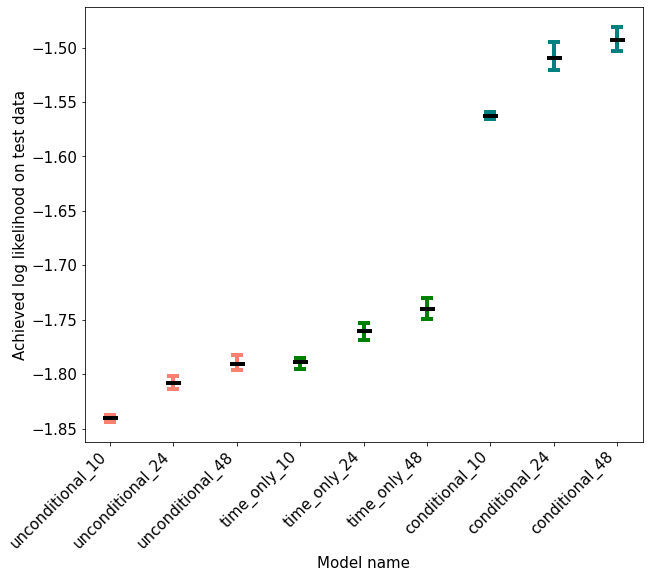

In [39]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,8))
boxes = plt.errorbar(uncond_model_names, uncond_means, yerr=[uncond_lower_err, uncond_upper_err],
             linestyle="",
             marker='_',
             color='black',
             mew=4,
             markersize=15,
             capsize=6,
             elinewidth=4,
             ecolor='salmon'
                )
boxes = plt.errorbar(time_only_model_names, time_only_means, yerr=[time_only_lower_err, time_only_upper_err],
             linestyle="",
             marker='_',
             color='black',
             mew=4,
             markersize=15,
             capsize=6,
             elinewidth=4,
             ecolor='green'
                )
boxes = plt.errorbar(cond_model_names, cond_means, yerr=[cond_lower_err, cond_upper_err],
             linestyle="",
             marker='_',
             color='black',
             mew=4,
             markersize=15,
             capsize=6,
             elinewidth=4,
             ecolor='teal'
                )
plt.xticks(model_names, model_names, rotation=45, ha='right')
plt.yticks()
plt.xlabel('Model name')
plt.ylabel('Achieved log likelihood on test data')

for i, box in enumerate(boxes):
    print(box)


plt.show()